In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime as dt
import decouple
#from performance_stats import *
#from data_prep import *
#from loss_fcn import *
#from train_test import *
#from models import CNN_port
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load tickers
config = decouple.AutoConfig(' ')
path = config('PATH_MY_MAIN_DATA')
tickers = pd.read_csv(path+'/_data_vol_tickers')
tickers = list(tickers.iloc[:, 1])
len(tickers)

315

In [4]:
def reduce_features(df, drop_columns):
    for col in df.columns:
        for dc in drop_columns:
            if dc in col:
                df = df.drop(col, axis=1)
    return df

def train_val_test(data, lookback=30, train_years=5, val_years=1, test_years=1):
    
    # make train df
    year = data.index[0].year
    x = data[dt(year+1,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
    index_start_train = data.index.get_loc(x) - lookback
    x = data[dt(year+1+train_years,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
    index_end_train = data.index.get_loc(x) - lookback
    
    df_train = data.iloc[index_start_train:index_end_train, :]
    
    # make validation df
    index_start_val = data.index.get_loc(df_train.index[-1].strftime("%Y-%m-%d")) + 1
    x = data[dt(year+1+train_years+val_years,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
    index_end_val = data.index.get_loc(x) - lookback
    
    df_val = data.iloc[index_start_val:index_end_val, :]
    
    # make test df
    index_start_test = data.index.get_loc(df_val.index[-1].strftime("%Y-%m-%d")) + 1
    if train_years == 13:
        x = data[dt(year+train_years+val_years+test_years,1,1,0,0,0):].last_valid_index().strftime("%Y-%m-%d")
        index_end_test = data.index.get_loc(x) + 1
    else:
        x = data[dt(year+1+train_years+val_years+test_years,1,1,0,0,0):].first_valid_index().strftime("%Y-%m-%d")
        index_end_test = data.index.get_loc(x) 
    
    df_test = data.iloc[index_start_test:index_end_test, :]
    
    return df_train.sort_index(), df_val.sort_index(),  df_test.sort_index()

def get_targets(dataframe, iv=60, ten_day=False):
    if ten_day:
        x = 'IvMean' + str(iv) + '_return_ten'
        targets = [dataframe[col] for col in dataframe.columns if x in col]
        targets = pd.DataFrame(targets).transpose()
    else:
        x = 'IvMean' + str(iv) + '_return_next'
        targets = [dataframe[col] for col in dataframe.columns if x in col] 
        targets = pd.DataFrame(targets).transpose()
    return targets

def get_features(dataframe):
    features = [dataframe[col] for col in dataframe.columns if 'return' not in col]
    features = pd.DataFrame(features).transpose()
    return features
    
def standardize(dataframe):
    df_standardized = pd.DataFrame()
    for col in dataframe.columns:
        col_mean = dataframe[col].mean()
        col_std = dataframe[col].std()
        df_standardized[col] = (dataframe[col] - col_mean) / col_std
    return df_standardized

def unstandardize(df_stand, df_orig):
    if len(df_stand.columns) == len(df_orig.columns):
        df_un = pd.DataFrame()
        for i, col in enumerate(df_stand.columns):
            col_og = df_orig.columns[i]
            df_un[col] = df_stand[col] * df_orig[col_og].std() + df_orig[col_og].mean()
        return df_un
    else:
        print("Value Error: Dataframes must have same column lengths")

In [294]:
class TS_Dataset(Dataset):
    def __init__(self, dataframe,lookback=20, iv=60):
        self.lookback = lookback
        self.X = torch.tensor(standardize(get_features(dataframe)).values).float()
        self.y = torch.tensor(standardize(get_targets(dataframe, iv=iv)).values).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        if i >= self.lookback - 1:
            i_start = i - self.lookback + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.lookback - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [6]:
def abs_softmax(x):
    """Returns weights with absolute values that sum to 1"""
    means = torch.mean(x, dim=1, keepdim=True)
    x_exp = torch.exp(x.abs()- means)
    x_exp_sum = torch.sum(x_exp,  dim=1, keepdims=True)
    
    return torch.sign(x)*x_exp/x_exp_sum


def sharpe_loss(weights, returns):
    """Calculate Sharpe ratio given by model weights"""
    portfolio_returns = weights.multiply(returns).sum(dim=1)
    sharpe = portfolio_returns.mean() / portfolio_returns.std()
    return -sharpe

def return_loss(weights, returns):
    portfolio_returns = weights.multiply(returns).sum(dim=1)
    return - portfolio_returns
# still uncertain if this is specified correctly or not due to 
# best way to do i

In [156]:
#  code from crosstab article
class LSTM_port(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=315)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.
        out = torch.flatten(out, 1)
        
        out = abs_softmax(out)
        return out

In [8]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()
    

    avg_loss = total_loss / num_batches
    return avg_loss

def early_stop(losses, tolerance=5):
    min_loss_idx = losses.index(min(losses))
    since_new_min = len(losses) - 1 - min_loss_idx
    if since_new_min >= tolerance:
        return True
    
def plot_losses(train_losses, val_losses):
    x = range(len(train_losses))
    plt.plot(x, train_losses, label='Train Loss')
    plt.plot(x, val_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.show()

def plot_returns(p_return, bm_return, returns=True):
    x = range(len(p_return))
    if returns:
        plt.plot(x, p_return, label='Portfolio Return')
        plt.plot(x, bm_return, label='Benchmark Return')
    else:
        plt.plot(x, p_return, label='Portfolio Sharpe')
        plt.plot(x, bm_return, label='Benchmark Sharpe')
    plt.legend(loc='upper left')
    plt.show()

In [300]:
# define functions for obtaining/visualizing predictions
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

def get_pred_df_sharpe(df_train, df_test, model, batch_size,
                       lookback, tickers, num_assets=15, iv=60, test_only=False):
    """Create dataframe with actual and un-normalized predicted return values """
    
    train_dataset = TS_Dataset(df_train, lookback=lookback, iv=iv)
    test_dataset = TS_Dataset(df_test, lookback=lookback, iv=iv)
    test_loader = DataLoader(test_dataset,
                        batch_size,
                        shuffle=False)
    
    train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    y_hat = '_port_weight'
    targets = get_targets(df_train, iv=iv)
    column_names = [col[21:] + y_hat for col in targets.columns]
    
    df_out_train = pd.DataFrame(predict(train_eval_loader, model).numpy(),
                         columns=column_names,
                         index=df_train.index)


    df_out_train = targets.join(df_out_train)
    
    df_out_test = pd.DataFrame(predict(test_loader, model).numpy(),
                              columns=column_names,
                              index=df_test.index)

    df_out_test = get_targets(df_test, iv=iv).join(df_out_test)
    
    df_out = pd.concat((df_out_train, df_out_test))

    df_out['return_next_portfolio'] = (df_out.iloc[:, num_assets:].values * df_out.iloc[:, :num_assets].values).sum(axis=1)
    df_out['return_portfolio'] = df_out['return_next_portfolio'].shift(1)
    
    # add benchmark column
    weight = 1 / num_assets
    weights = np.repeat(weight, num_assets)    
    df_out['return_next_benchmark'] = (df_out.iloc[:, :num_assets].values * weights).sum(axis=1)
    df_out['return_benchmark'] = df_out['return_next_benchmark'].shift(1)
    
    # add costs
#    df_out = turnover_cost(df_out, tickers, bps=1)
    
    if test_only:
        year = df_test.index[0].year + 1
        date = str(year) + '-01-01'
        return df_out[df_out.index >= date]
    else:
        return df_out


In [10]:
def total_return(return_col, start = True, stop = True, annualized=True):
    if start:
        start = return_col.index[0]
    if stop:
        stop = return_col.index[-1]
    if start > stop:
        print("Index Error: Start given is after Stop given")
    else:
        return_col = return_col[(return_col.index >= start) & (return_col.index <= stop)]
        return_col = return_col + 1
        ttl_return = 1
        for i in range(len(return_col)):
                ttl_return *= return_col[i]
        days  = (pd.to_datetime(stop) - pd.to_datetime(start)).days
        years = days / 365
        annualized_return = ttl_return ** (1 / years) - 1
        ttl_return -= 1
        if annualized == True:
            return annualized_return
        else:
            return ttl_return

def return_std(return_col, start = True, stop = True, annualized=True):
    if start:
        start = return_col.index[0]
    if stop:
        stop = return_col.index[-1]    
    if start > stop:
        print("Index Error: Start given is after Stop given")
    else:
        return_col = return_col[(return_col.index >= start) & (return_col.index <= stop)]
        if annualized:
            return return_col.std() * np.sqrt(250)
        else:
            return return_col.std()

def sharpe_ratio(return_col, start = True, stop = True):
    if start:
        start = return_col.index[0]
    if stop:
        stop = return_col.index[-1]
    ann_return = total_return(return_col, start, stop, annualized=True)
    ann_std = return_std(return_col, start, stop, annualized=True)
    
    return ann_return / ann_std

def turnover_cost(df_pred, tickers, bps=1):
    """Calculate costs from asset turnover"""
    df_pred = df_pred.sort_index(ascending=True)
    port_value = 1 # assume portfolio value = 1 after first time period
    costs = []
    cost_returns = []
    for i in range(df_pred.shape[0] - 1):
        cost_ticker = []
        for j, ticker in enumerate(tickers):
            asset_value_0 = port_value * df_pred[str(tickers[j]) + '_port_weight'][i]
            asset_value_1 = asset_value_0 * (1 + df_pred['return_next_' + str(tickers[j])][i])
            port_value_next = port_value * (1+df_pred['return_next_portfolio'][i])
            asset_value_next =  port_value_next * df_pred[str(tickers[j]) + '_port_weight'][i+1]        
            val_change = np.abs((asset_value_next - asset_value_1))
            cost = val_change * bps / 10000 * -1
            cost_ticker.append(cost)
        cost_sum = np.sum(cost_ticker)
        costs.append(cost_sum)
        cost_return = cost_sum / port_value
        cost_returns.append(cost_return)
        port_value *= (1 + df_pred['return_next_portfolio'][i] + cost_return)
    cost_returns.append(0)
    df_pred['cost_return_next'] = cost_returns
    df_pred['cost_return'] = df_pred['cost_return_next'].shift(1)
    df_pred['total_portfolio_return'] = df_pred['cost_return'] + df_pred['return_portfolio']
    return df_pred


In [5]:
config = decouple.AutoConfig(' ')
path = config('PATH_MY_MAIN_DATA')
data = pd.read_csv(path+'/_data_set_vol', index_col='date', parse_dates=True)
data = reduce_features(data, ['IvMean120', 'ticker'])
pd.options.display.max_columns = None
data.head()

IvMean60_A  IvMean90_A  IvMean360_A  Phv10_A  Phv60_A  \
date                                                                
2007-11-01      0.3451      0.3314       0.3224   0.2653   0.1952   
2007-11-02      0.3396      0.3297       0.3256   0.2665   0.1965   
2007-11-05      0.3406      0.3354       0.3267   0.2566   0.1989   
2007-11-06      0.3291      0.3273       0.3249   0.2219   0.1997   
2007-11-07      0.3466      0.3416       0.3294   0.2429   0.2044   

            IvMeanSkew10_A  IvMeanSkew60_A  IvMeanSkew360_A  return_A  \
date                                                                    
2007-11-01          0.0475          0.0424           0.0170 -0.016271   
2007-11-02          0.0452          0.0722           0.0166 -0.006663   
2007-11-05          0.0866          0.0880           0.0175 -0.009246   
2007-11-06          0.0188          0.0384           0.0155  0.012178   
2007-11-07          0.0155          0.0756           0.0162 -0.029638   

            norm_adjclose_A  norm_adj_range_pct_A  volume_dollars_MM_A  \
date                                                                     
2007-11-01        82.409091              0.022634              70.4720   
2007-11-02        81.863636              0.025309              47.6393   
2007-11-05        81.113636              0.023655              75.8815   
2007-11-06        82.113636              0.024029              79.4667   
2007-11-07        79.750000              0.031996              75.7568   

            IvMean60_return_next_A  IvMean90_return_next_A  \
date                                                         
2007-11-01               -0.015937               -0.005130   
2007-11-02                0.002945                0.017288   
2007-11-05               -0.033764               -0.024150   
2007-11-06                0.053175                0.043691   
2007-11-07                0.038373                0.033665   

            IvMean60_return_prev_A  IvMean90_return_prev_A  \
date                                                         
2007-11-01                     NaN                     NaN   
2007-11-02               -0.015937               -0.005130   
2007-11-05                0.002945                0.017288   
2007-11-06               -0.033764               -0.024150   
2007-11-07                0.053175                0.043691   

            IvMean60_return_ten_next_A  IvMean90_return_ten_next_A  \
date                                                                 
2007-11-01                    0.018835                    0.094448   
2007-11-02                   -0.159894                   -0.047619   
2007-11-05                   -0.141809                   -0.046810   
2007-11-06                   -0.154968                   -0.046135   
2007-11-07                   -0.161858                   -0.063817   

            IvMean60_AAP  IvMean90_AAP  IvMean360_AAP  Phv10_AAP  Phv60_AAP  \
date                                                                          
2007-11-01        0.3259        0.3324         0.3312     0.3865     0.3035   
2007-11-02        0.3283        0.3364         0.3471     0.3352     0.3072   
2007-11-05        0.3418        0.3429         0.3469     0.3788     0.3155   
2007-11-06        0.3236        0.3312         0.3457     0.4065     0.3167   
2007-11-07        0.3437        0.3461         0.3461     0.4091     0.3168   

            IvMeanSkew10_AAP  IvMeanSkew60_AAP  IvMeanSkew360_AAP  return_AAP  \
date                                                                            
2007-11-01            0.0302            0.0307             0.0203    0.026811   
2007-11-02            0.0311            0.0314             0.0272   -0.008051   
2007-11-05            0.0122            0.0138             0.0263    0.010526   
2007-11-06            0.0354            0.0356             0.0403    0.036458   
2007-11-07            0.0260            0.0266             0.0247   -0.008013   

            no

In [13]:
iv60 = [col for col in data.columns if ('IvMean60' in col) & ('return' not in col)]
iv90 = [col for col in data.columns if ('IvMean90' in col) & ('return' not in col)]

df_60 = data[iv60]
df_60.head()
df_90 = data[iv90]
df_90.head()

,IvMean90_A,IvMean90_AAP,IvMean90_AAPL,IvMean90_ABC,IvMean90_ABT,IvMean90_ACN,IvMean90_ADBE,IvMean90_ADI,IvMean90_ADM,IvMean90_ADP,IvMean90_ADSK,IvMean90_AEP,IvMean90_AES,IvMean90_AFL,IvMean90_AIZ,IvMean90_AKAM,IvMean90_ALB,IvMean90_ALGN,IvMean90_ALK,IvMean90_ALL,IvMean90_AMAT,IvMean90_AMGN,IvMean90_AMP,IvMean90_AMT,IvMean90_AMZN,IvMean90_ANSS,IvMean90_APA,IvMean90_APD,IvMean90_APH,IvMean90_ASML,IvMean90_AVB,IvMean90_AVY,IvMean90_AXP,IvMean90_AZN,IvMean90_AZO,IvMean90_BA,IvMean90_BAC,IvMean90_BAX,IvMean90_BBY,IvMean90_BDX,IvMean90_BEN,IvMean90_BIIB,IvMean90_BK,IvMean90_BLK,IvMean90_BMY,IvMean90_BSX,IvMean90_BWA,IvMean90_BXP,IvMean90_CAG,IvMean90_CAH,IvMean90_CAT,IvMean90_CCI,IvMean90_CCL,IvMean90_CDNS,IvMean90_CE,IvMean90_CF,IvMean90_CHRW,IvMean90_CI,IvMean90_CL,IvMean90_CLX,IvMean90_CMA,IvMean90_CMCSA,IvMean90_CME,IvMean90_CMI,IvMean90_CNC,IvMean90_COF,IvMean90_COO,IvMean90_COP,IvMean90_COST,IvMean90_CPB,IvMean90_CRL,IvMean90_CRM,IvMean90_CSCO,IvMean90_CSX,IvMean90_CTAS,IvMean90_CTSH,IvMean90_CVS,IvMean90_CVX,IvMean90_D,IvMean90_DE,IvMean90_DGX,IvMean90_DHI,IvMean90_DHR,IvMean90_DIA,IvMean90_DIS,IvMean90_DISH,IvMean90_DLR,IvMean90_DLTR,IvMean90_DOV,IvMean90_DPZ,IvMean90_DRI,IvMean90_DVA,IvMean90_DVN,IvMean90_EBAY,IvMean90_ECL,IvMean90_EEM,IvMean90_EFA,IvMean90_EIX,IvMean90_EL,IvMean90_EMN,IvMean90_EMR,IvMean90_EOG,IvMean90_EQIX,IvMean90_EQR,IvMean90_EQT,IvMean90_ESS,IvMean90_ETN,IvMean90_EW,IvMean90_EXC,IvMean90_EXPD,IvMean90_EXPE,IvMean90_FAST,IvMean90_FCX,IvMean90_FDS,IvMean90_FDX,IvMean90_FE,IvMean90_FFIV,IvMean90_FISV,IvMean90_FMC,IvMean90_GD,IvMean90_GE,IvMean90_GILD,IvMean90_GIS,IvMean90_GLW,IvMean90_GOOGL,IvMean90_GPC,IvMean90_GPN,IvMean90_GRMN,IvMean90_GS,IvMean90_GWW,IvMean90_HAL,IvMean90_HAS,IvMean90_HBAN,IvMean90_HD,IvMean90_HES,IvMean90_HIG,IvMean90_HOLX,IvMean90_HON,IvMean90_HPQ,IvMean90_HSIC,IvMean90_HST,IvMean90_HSY,IvMean90_HUM,IvMean90_IBM,IvMean90_ICE,IvMean90_IDXX,IvMean90_IFF,IvMean90_ILMN,IvMean90_INTC,IvMean90_INTU,IvMean90_IPG,IvMean90_IRM,IvMean90_ISRG,IvMean90_ITW,IvMean90_IWM,IvMean90_JBHT,IvMean90_JCI,IvMean90_JNJ,IvMean90_JNPR,IvMean90_JPM,IvMean90_K,IvMean90_KEY,IvMean90_KLAC,IvMean90_KMB,IvMean90_KMX,IvMean90_KO,IvMean90_KR,IvMean90_LEN,IvMean90_LH,IvMean90_LLY,IvMean90_LMT,IvMean90_LNC,IvMean90_LOW,IvMean90_LRCX,IvMean90_LUV,IvMean90_MAR,IvMean90_MAS,IvMean90_MCD,IvMean90_MCHP,IvMean90_MCK,IvMean90_MCO,IvMean90_MDT,IvMean90_MDY,IvMean90_MET,IvMean90_MGM,IvMean90_MHK,IvMean90_MLM,IvMean90_MMM,IvMean90_MO,IvMean90_MOS,IvMean90_MPWR,IvMean90_MRK,IvMean90_MRO,IvMean90_MRVL,IvMean90_MS,IvMean90_MSFT,IvMean90_MTB,IvMean90_NDAQ,IvMean90_NEM,IvMean90_NFLX,IvMean90_NKE,IvMean90_NOC,IvMean90_NRG,IvMean90_NSC,IvMean90_NTAP,IvMean90_NTRS,IvMean90_NUE,IvMean90_NVDA,IvMean90_NWL,IvMean90_ODFL,IvMean90_OKE,IvMean90_OMC,IvMean90_ORCL,IvMean90_ORLY,IvMean90_OXY,IvMean90_PAYX,IvMean90_PCAR,IvMean90_PEP,IvMean90_PFE,IvMean90_PFG,IvMean90_PG,IvMean90_PGR,IvMean90_PH,IvMean90_PHM,IvMean90_PKG,IvMean90_PNC,IvMean90_PNR,IvMean90_POOL,IvMean90_PPG,IvMean90_PRU,IvMean90_PSA,IvMean90_PWR,IvMean90_PXD,IvMean90_QCOM,IvMean90_QQQ,IvMean90_RCL,IvMean90_RE,IvMean90_REGN,IvMean90_RF,IvMean90_RJF,IvMean90_RL,IvMean90_RMD,IvMean90_ROK,IvMean90_ROP,IvMean90_ROST,IvMean90_SBAC,IvMean90_SBUX,IvMean90_SCHW,IvMean90_SEE,IvMean90_SGEN,IvMean90_SHW,IvMean90_SIRI,IvMean90_SIVB,IvMean90_SJM,IvMean90_SLB,IvMean90_SNA,IvMean90_SO,IvMean90_SPG,IvMean90_SPY,IvMean90_SRE,IvMean90_STT,IvMean90_STX,IvMean90_STZ,IvMean90_SWK,IvMean90_SWKS,IvMean90_SYK,IvMean90_SYY,IvMean90_T,IvMean90_TAP,IvMean90_TER,IvMean90_TGT,IvMean90_TJX,IvMean90_TMO,IvMean90_TRMB,IvMean90_TROW,IvMean90_TRV,IvMean90_TSCO,IvMean90_TSN,IvMean90_TTWO,IvMean90_TXN,IvMean90_TXT,IvMean90_UHS,IvMean90_UNH,IvMean90_UNP,IvMean90_UPS,IvMean90_USB,IvMean90_VLO,IvMean90_VMC,IvMean90_VNO,IvMean90_VRSN,IvMean90_VRTX,IvMean90_VWO,IvMean90_VZ,IvMean90_WAB,IvMean90_WAT,IvMean90_WDC,IvMean90_WFC,IvMean90_WHR,IvMean90_WMB,IvMean90_WMT,IvMean90_WY,IvMean90_WYNN,IvMean90_XLE,IvMean90_XLF,IvMean

In [23]:
(df_60.mean().mean() - df_90.mean().mean())/ df_60.mean().mean()

-0.0008865931896779837

In [306]:
torch.manual_seed(109)

batch_size = 32
lookback = 30
iv = 60

df_train, df_val, df_test = train_val_test(data, lookback, train_years=6) 

train_dataset = TS_Dataset(df_train, lookback=lookback, iv=iv)
val_dataset = TS_Dataset(df_val, lookback=lookback, iv=iv)
test_dataset = TS_Dataset(df_test, lookback=lookback, iv=iv)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)



Features shape: torch.Size([32, 30, 3465])
Target shape: torch.Size([32, 315])


In [173]:
# hyperparam testing
lr = 0.0001
num_hidden_units = 512

min_val_loss = []
time = []

model = LSTM_port(num_sensors=get_features(df_train).shape[1], hidden_units=num_hidden_units)
loss_function = sharpe_loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []
t0 = dt.now()
for epoch in range(100):
    t00 = dt.now()
    print(f"Epoch {epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    val_loss = test_model(val_loader, model, loss_function)
    val_losses.append(val_loss)
    t01 = dt.now()
    T1 = (t01 - t00).total_seconds()
    print('Train loss: {}'.format(train_loss))
    print('Validation loss: {}'.format(val_loss))
    print('Time to train: {} seconds'.format(T1))
    print()
        
    if early_stop(val_losses, tolerance=100):
        print('Early Stop Triggered')
        break
val_losses.sort()        
x = val_losses
x = np.mean(x[:5])
min_val_loss.append(x)
t1 = dt.now()
T = (t1 - t0).total_seconds()
time.append(T)
print('Time to train: {} seconds'.format(T))

print('Total time: {} seconds'.format(np.sum(time)))

Epoch 0
---------
Train loss: -0.04971356736496091
Validation loss: nan
Time to train: 3.226765 seconds

Epoch 1
---------
Train loss: -0.788775697350502
Validation loss: nan
Time to train: 3.000765 seconds

Epoch 2
---------
Train loss: -1.0813322365283966
Validation loss: nan
Time to train: 2.958468 seconds

Epoch 3
---------
Train loss: -1.5007146447896957
Validation loss: nan
Time to train: 2.984499 seconds

Epoch 4
---------
Train loss: -1.570821538567543
Validation loss: nan
Time to train: 3.129302 seconds

Epoch 5
---------
Train loss: -1.46592216193676
Validation loss: nan
Time to train: 3.005867 seconds

Epoch 6
---------
Train loss: -1.7942157685756683
Validation loss: nan
Time to train: 3.075641 seconds

Epoch 7
---------
Train loss: -1.3931763619184494
Validation loss: nan
Time to train: 3.057407 seconds

Epoch 8
---------


KeyboardInterrupt: 

In [307]:
# test model
lr = 0.0001
num_hidden_units = 512
iv=60

min_val_loss = []
time = []

model = LSTM_port(num_sensors=get_features(df_train).shape[1], hidden_units=num_hidden_units)
loss_function = sharpe_loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print("Untrained test\n--------")
test_model(val_loader, model, loss_function)
print()

# loop through different time periods
df_predictions = pd.DataFrame()
test_losses = []
benchmark_returns = []
benchmark_sharpe = []
portfolio_returns = []
portfolio_sharpe = []
for i in range(9):
    t0 = dt.now()
    df_train, df_val, df_test = train_val_test(data, lookback, train_years=5+i) 

    train_dataset = TS_Dataset(df_train, lookback=lookback, iv=iv)
    val_dataset = TS_Dataset(df_val, lookback=lookback, iv=iv)
    test_dataset = TS_Dataset(df_test, lookback=lookback, iv=iv)

    # Should I shuffle data for models with memory? RNN order matters
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)


    train_losses = []
    val_losses = []
    for epoch in range(100):
        print(f"Epoch {epoch}\n---------")
        train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
        train_losses.append(train_loss)
        val_loss = test_model(val_loader, model, loss_function)
        val_losses.append(val_loss)
    
        if early_stop(val_losses, tolerance=100):
            print('Early Stop Triggered')
            break
    
        print('Train loss: {}'.format(train_loss))
        print('Validation loss: {}'.format(val_loss))
        print()
    test_loss = test_model(test_loader, model, loss_function)
    test_losses.append(test_loss)
    
    df_int = get_pred_df_sharpe(df_train,
                                df_test,
                                model=model,
                                batch_size=batch_size,
                                num_assets=315,
                                lookback=lookback,
                                iv=iv,
                                tickers=tickers,
                                test_only=True)
    df_predictions = pd.concat([df_predictions, df_int]).sort_index(ascending=True)
    
    bm_r = total_return(df_int['return_benchmark'][1:])
    bm_s = sharpe_ratio(df_int['return_benchmark'][1:])
    p_r = total_return(df_int['return_portfolio'][1:])
    p_s = sharpe_ratio(df_int['return_portfolio'][1:])
    
    benchmark_returns.append(bm_r)
    benchmark_sharpe.append(bm_s)
    portfolio_returns.append(p_r)
    portfolio_sharpe.append(p_s)
    
    t1 = dt.now()
    T = (t1 - t0).total_seconds()
    print()
    print('Test loss: {} Portfolio return: {}, Portfolio Sharpe: {}'.format(test_loss, p_r, p_s))
    print('Benchmark return: {}, Benchmark Sharpe: {}'.format(bm_r, bm_s))
    
    print('Total seconds to train:  {}'.format(T))




Untrained test
--------

Epoch 0
---------
Train loss: 0.024983665555191693
Validation loss: -0.19191556610167027

Epoch 1
---------
Train loss: -0.13863857886753977
Validation loss: -0.17027786001563072

Epoch 2
---------
Train loss: -0.30766722476109865
Validation loss: -0.15865809191018343

Epoch 3
---------
Train loss: -0.5707560708746314
Validation loss: -0.10036867600865662

Epoch 4
---------
Train loss: -0.7643717885017395
Validation loss: -0.19467862439341843

Epoch 5
---------
Train loss: -0.9486169673502445
Validation loss: -0.15706232748925686

Epoch 6
---------
Train loss: -1.1059393301606177
Validation loss: -0.18294554203748703

Epoch 7
---------
Train loss: -1.1459893882274628
Validation loss: -0.2097790741827339

Epoch 8
---------
Train loss: -1.2889325350522995
Validation loss: -0.1954232743009925

Epoch 9
---------
Train loss: -1.4041044577956199
Validation loss: -0.16835386236198246

Epoch 10
---------
Train loss: -1.5656991854310036
Validation loss: -0.1524137930182

Train loss: -4.978695493936539
Validation loss: -0.17830328550189734

Epoch 93
---------
Train loss: -5.5693239867687225
Validation loss: -0.1784108938591089

Epoch 94
---------
Train loss: -5.441274005174637
Validation loss: -0.17070758854970336

Epoch 95
---------
Train loss: -5.4511574625968935
Validation loss: -0.16971504408866167

Epoch 96
---------
Train loss: -5.754573845863343
Validation loss: -0.1817586738616228

Epoch 97
---------
Train loss: -5.85339263677597
Validation loss: -0.1975028640590608

Epoch 98
---------
Train loss: -5.829579764604569
Validation loss: -0.1844821401173249

Epoch 99
---------
Train loss: -5.4263602793216705
Validation loss: -0.1732066348195076


Test loss: -0.07955582284679015 Portfolio return: 0.11237608733742732, Portfolio Sharpe: 1.2382337765460851
Benchmark return: 0.27001967865155097, Benchmark Sharpe: 0.7313631272116509
Total seconds to train:  1286.740375
Epoch 0
---------
Train loss: -2.2906680641074977
Validation loss: -0.0342109048506245



Train loss: -7.122921322782834
Validation loss: -0.08507394214393571

Epoch 83
---------
Train loss: -6.328131886819999
Validation loss: -0.06921901740133762

Epoch 84
---------
Train loss: -7.379564983149369
Validation loss: -0.09425232085050084

Epoch 85
---------
Train loss: -6.279148519039154
Validation loss: -0.08303658780641854

Epoch 86
---------
Train loss: -7.324294830362002
Validation loss: -0.08454235555836931

Epoch 87
---------
Train loss: -6.413583070039749
Validation loss: -0.08107716523227282

Epoch 88
---------
Train loss: -7.369430368145307
Validation loss: -0.07971599162556231

Epoch 89
---------
Train loss: -6.824712753295898
Validation loss: -0.08581482147565112

Epoch 90
---------
Train loss: -7.87796738743782
Validation loss: -0.09503007191233337

Epoch 91
---------
Train loss: -6.976569026708603
Validation loss: -0.08128216257318854

Epoch 92
---------
Train loss: -7.285381148258845
Validation loss: -0.08501021703705192

Epoch 93
---------
Train loss: -3.5161963

Train loss: -3.6073356260146414
Validation loss: -0.11540275276638567

Epoch 73
---------
Train loss: -3.8281156899673596
Validation loss: -0.1265841197455302

Epoch 74
---------
Train loss: -4.039428955742291
Validation loss: -0.1206931023625657

Epoch 75
---------
Train loss: -4.133370645344257
Validation loss: -0.12404766329564154

Epoch 76
---------
Train loss: -4.30829954040902
Validation loss: -0.1325027918210253

Epoch 77
---------
Train loss: -4.450234376958439
Validation loss: -0.12229536124505103

Epoch 78
---------
Train loss: -4.397909716836044
Validation loss: -0.12227022484876215

Epoch 79
---------
Train loss: -4.425512393670423
Validation loss: -0.11825699309702031

Epoch 80
---------
Train loss: -4.812519046877112
Validation loss: -0.12992964498698711

Epoch 81
---------
Train loss: -3.239611968398094
Validation loss: -0.14098269780515693

Epoch 82
---------
Train loss: -4.789880474763257
Validation loss: -0.1103196999465581

Epoch 83
---------
Train loss: -1.623930769

Train loss: -6.8264820954156304
Validation loss: -0.20345377502962947

Epoch 63
---------
Train loss: -6.532111188722035
Validation loss: -0.2123145938385278

Epoch 64
---------
Train loss: -7.050980473321582
Validation loss: -0.19851800659671426

Epoch 65
---------
Train loss: -6.292811666216169
Validation loss: -0.21200561802834272

Epoch 66
---------
Train loss: -6.955505706015087
Validation loss: -0.20920682372525334

Epoch 67
---------
Train loss: -7.079006550804017
Validation loss: -0.2103601498529315

Epoch 68
---------
Train loss: -6.777110096008059
Validation loss: -0.2127519203349948

Epoch 69
---------
Train loss: -7.222107906190176
Validation loss: -0.19633112847805023

Epoch 70
---------
Train loss: -7.082927921461681
Validation loss: -0.21382193826138973

Epoch 71
---------
Train loss: -6.997324604836721
Validation loss: -0.21941136056557298

Epoch 72
---------
Train loss: -7.261928206398373
Validation loss: -0.2065022992901504

Epoch 73
---------
Train loss: -6.881320493

Train loss: -7.543181899567725
Validation loss: -0.24112912447890267

Epoch 54
---------
Train loss: -8.438429345547313
Validation loss: -0.25014462787657976

Epoch 55
---------
Train loss: -8.27823758461106
Validation loss: -0.24327722284942865

Epoch 56
---------
Train loss: -8.235398980933176
Validation loss: -0.2468342101201415

Epoch 57
---------
Train loss: -8.383921629945997
Validation loss: -0.241755350260064

Epoch 58
---------
Train loss: -8.28901370478348
Validation loss: -0.2432276178151369

Epoch 59
---------
Train loss: -8.503917600067568
Validation loss: -0.26152595272287726

Epoch 60
---------
Train loss: -8.7448382579105
Validation loss: -0.25276811604271643

Epoch 61
---------
Train loss: -8.47453854117595
Validation loss: -0.2485990533605218

Epoch 62
---------
Train loss: -9.051064649098356
Validation loss: -0.25324798142537475

Epoch 63
---------
Train loss: -8.907199008364072
Validation loss: -0.24585010716691613

Epoch 64
---------
Train loss: -8.950722439188352


Train loss: -8.735188411760934
Validation loss: -0.20201174530666322

Epoch 45
---------
Train loss: -8.404984112027325
Validation loss: -0.22880593361333013

Epoch 46
---------
Train loss: -8.7585243967515
Validation loss: -0.23071237397380173

Epoch 47
---------
Train loss: -9.045474203327034
Validation loss: -0.22611535666510463

Epoch 48
---------
Train loss: -8.809019312073913
Validation loss: -0.20690120791550726

Epoch 49
---------
Train loss: -8.823582504369035
Validation loss: -0.20105145685374737

Epoch 50
---------
Train loss: -8.830294062819663
Validation loss: -0.21221711614634842

Epoch 51
---------
Train loss: -9.474451722978037
Validation loss: -0.20580294262617826

Epoch 52
---------
Train loss: -8.862758564043649
Validation loss: -0.19617788610048592

Epoch 53
---------
Train loss: -9.031432670882985
Validation loss: -0.2152414721203968

Epoch 54
---------
Train loss: -9.420066036755525
Validation loss: -0.22293582663405687

Epoch 55
---------
Train loss: -9.431005888

Train loss: -8.78007839191919
Validation loss: -0.2887372234836221

Epoch 35
---------
Train loss: -8.357024902584909
Validation loss: -0.3023033430799842

Epoch 36
---------
Train loss: -8.750846542161087
Validation loss: -0.30299644637852907

Epoch 37
---------
Train loss: -8.415326389773139
Validation loss: -0.29751122649759054

Epoch 38
---------
Train loss: -8.331992152093472
Validation loss: -0.299012151081115

Epoch 39
---------
Train loss: -8.75414247622435
Validation loss: -0.3032373422756791

Epoch 40
---------
Train loss: -9.20309118566842
Validation loss: -0.2920276941731572

Epoch 41
---------
Train loss: -9.162275163606665
Validation loss: -0.29251638846471906

Epoch 42
---------
Train loss: -9.142544808058902
Validation loss: -0.2842464493587613

Epoch 43
---------
Train loss: -9.007043176683887
Validation loss: -0.2889339458197355

Epoch 44
---------
Train loss: -8.834386759790881
Validation loss: -0.2903629853390157

Epoch 45
---------
Train loss: -9.402210175305948
Va

Train loss: -7.945773890143947
Validation loss: -0.2676024613901973

Epoch 25
---------
Train loss: -7.566937106534055
Validation loss: -0.2561982199549675

Epoch 26
---------
Train loss: -8.18961507646661
Validation loss: -0.25733467750251293

Epoch 27
---------
Train loss: -7.545946216583252
Validation loss: -0.23812697548419237

Epoch 28
---------
Train loss: -8.197580328740571
Validation loss: -0.2569921677932143

Epoch 29
---------
Train loss: -8.42763402838456
Validation loss: -0.25912034045904875

Epoch 30
---------
Train loss: -8.043969174435265
Validation loss: -0.26150031201541424

Epoch 31
---------
Train loss: -8.932583575499685
Validation loss: -0.26380196399986744

Epoch 32
---------
Train loss: -8.304397045938591
Validation loss: -0.2710848515853286

Epoch 33
---------
Train loss: -8.537732212167038
Validation loss: -0.2623719573020935

Epoch 34
---------
Train loss: -8.944653142125983
Validation loss: -0.26332004833966494

Epoch 35
---------
Train loss: -8.9209566919427

Train loss: -5.696131253126755
Validation loss: -0.18994999583810568

Epoch 15
---------
Train loss: -6.146557544909634
Validation loss: -0.1998100457713008

Epoch 16
---------
Train loss: -6.091581302939109
Validation loss: -0.18561735190451145

Epoch 17
---------
Train loss: -5.720657989238072
Validation loss: -0.18249867763370275

Epoch 18
---------
Train loss: -6.030652939115913
Validation loss: -0.20491008553653955

Epoch 19
---------
Train loss: -6.0929567507169775
Validation loss: -0.19406621623784304

Epoch 20
---------
Train loss: -6.245592043237779
Validation loss: -0.1992367636412382

Epoch 21
---------
Train loss: -6.358166766398162
Validation loss: -0.19320563413202763

Epoch 22
---------
Train loss: -6.222073351295249
Validation loss: -0.19388226605951786

Epoch 23
---------
Train loss: -5.72340684376874
Validation loss: -0.1879262337461114

Epoch 24
---------
Train loss: -6.387386805224187
Validation loss: -0.20581811107695103

Epoch 25
---------
Train loss: -6.536617023

In [317]:
print(np.mean(portfolio_returns),
      np.mean(portfolio_sharpe),
      np.mean(benchmark_returns),
      np.mean(benchmark_sharpe))

0.2753305618484803 1.8909163370585764 0.28789521784296135 0.498903389737553


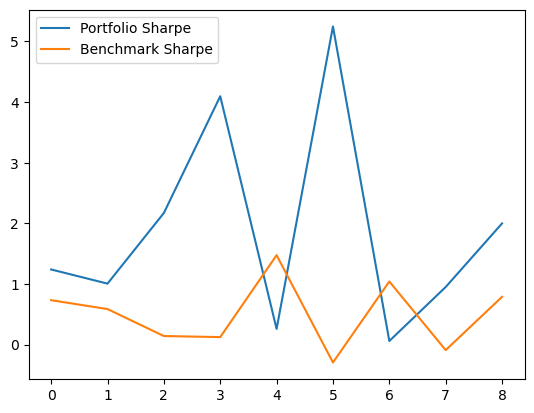

In [319]:
#plot_returns(portfolio_returns, benchmark_returns)
plot_returns(portfolio_sharpe, benchmark_sharpe, returns=False)

In [314]:
np.mean(portfolio_sharpe)

1.8909163370585764